In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import holidays
from datetime import date
from prophet import Prophet

# Model 1' - Random 10 MSPE (Prophet)


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TS/train2.csv")
data.head(2)

,item_id,timestamp,target
0,1,20220601 00,1085.28
1,1,20220601 01,1047.36


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_id    204000 non-null  int64  
 1   timestamp  204000 non-null  object 
 2   target     204000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ MB


In [ ]:
def convert_to_datetime(timestamp_str):
    return pd.to_datetime(timestamp_str, format='%Y%m%d %H', errors='coerce')

data['timestamp'] = data['timestamp'].apply(convert_to_datetime)

data.head()

,item_id,timestamp,target
0,1,2022-06-01 00:00:00,1085.28
1,1,2022-06-01 01:00:00,1047.36
2,1,2022-06-01 02:00:00,974.88
3,1,2022-06-01 03:00:00,953.76
4,1,2022-06-01 04:00:00,986.40


In [ ]:
data10 = data[data['item_id'].isin([10, 20, 30, 40, 50, 60, 71, 80, 90, 100])]

data10_eda = data10[data10['timestamp'] <= '2022-08-17 23:00:00']

## rdm10 EDA

In [ ]:
data10_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18720 entries, 18360 to 203831
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   item_id    18720 non-null  int64         
 1   timestamp  18720 non-null  datetime64[ns]
 2   target     18720 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 585.0 KB


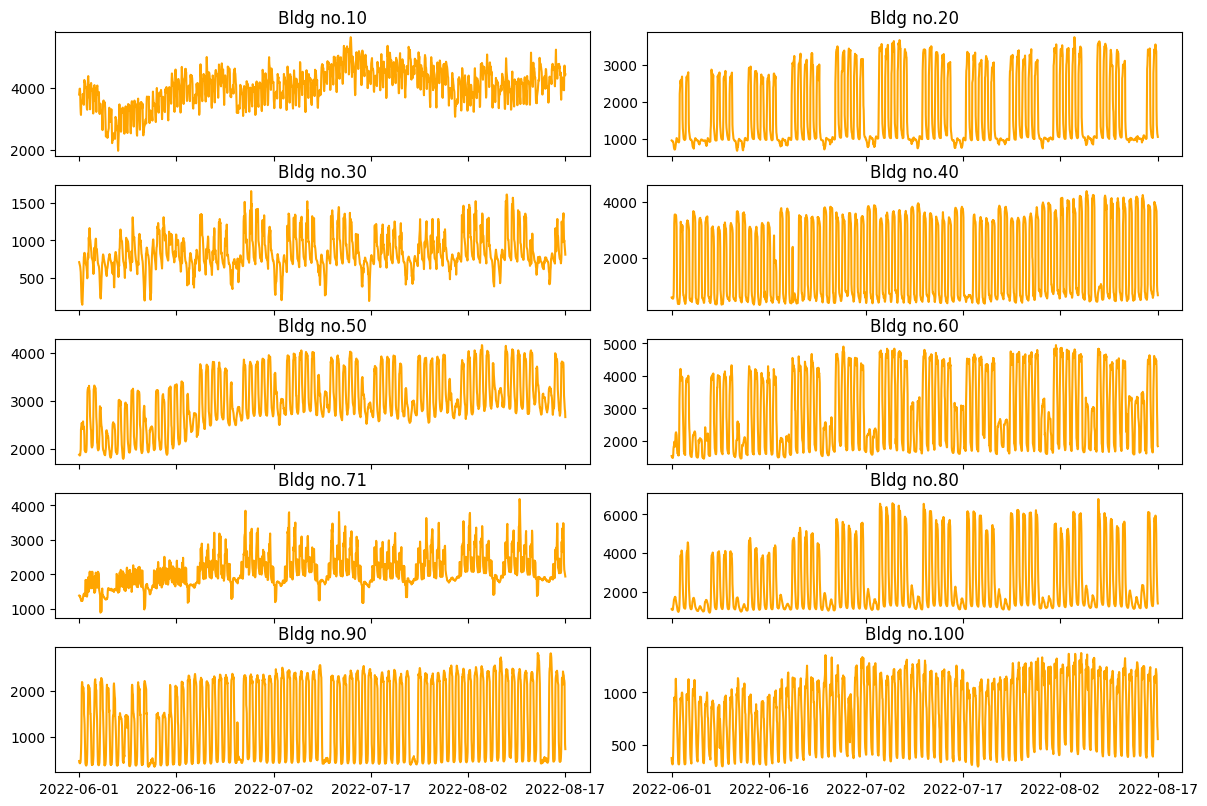

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8), sharex=True)
fig.tight_layout()

item_ids = [10, 20, 30, 40, 50, 60, 71, 80, 90, 100]
axes = axes.flatten()

for ax, item_id in zip(axes, item_ids):
    subset = data10_eda[data10_eda['item_id'] == item_id]
    ax.plot(subset['timestamp'], subset['target'], color='orange', label=f'Bldg no.{item_id}')
    ax.set_title(f'Bldg no.{item_id}')
    ax.set_xlabel('')

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax.set_xticks(subset['timestamp'][::max(1, len(subset) // 5)])

plt.show()

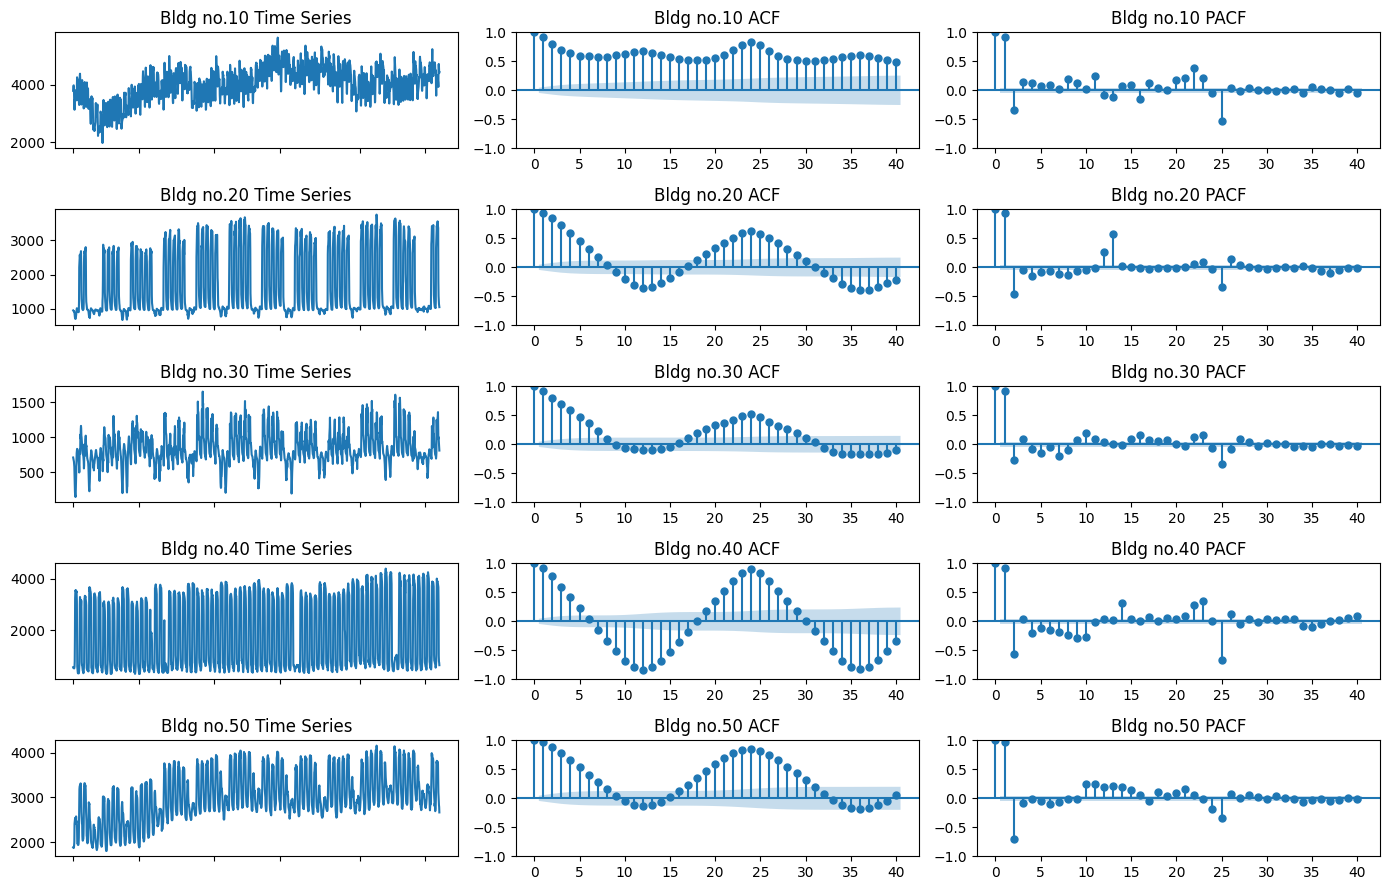

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 9))

item_ids = [10, 20, 30, 40, 50]

for i, item_id in enumerate(item_ids):
    subset = data10_eda[data10_eda['item_id'] == item_id]

    # time plot
    axes[i, 0].plot(subset['timestamp'], subset['target'])
    axes[i, 0].set_title(f'Bldg no.{item_id} Time Series')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')
    axes[i, 0].set_xticklabels([])

    # ACF plot
    sm.graphics.tsa.plot_acf(subset['target'], lags=40, ax=axes[i, 1])
    axes[i, 1].set_title(f'Bldg no.{item_id} ACF')

    # PACF plot
    sm.graphics.tsa.plot_pacf(subset['target'], lags=40, ax=axes[i, 2])
    axes[i, 2].set_title(f'Bldg no.{item_id} PACF')

plt.tight_layout()
plt.show()

## Modeling

In [ ]:
df1 = data10.reset_index()
df1['ds'] = df1['timestamp']
df1['y'] = df1['target']
df_rdm = df1[['item_id','ds','y']]
df_rdm.head()

,item_id,ds,y
0,10,2022-06-01 00:00:00,3785.76
1,10,2022-06-01 01:00:00,3867.84
2,10,2022-06-01 02:00:00,3972.48
3,10,2022-06-01 03:00:00,3976.80
4,10,2022-06-01 04:00:00,3855.36


In [ ]:
rdm_train = df_rdm[df_rdm['ds'] <= '2022-08-17 23:00:00']
rdm_test = df_rdm[df_rdm['ds'] >= '2022-08-18 0:00:00']

In [ ]:
results = {}
mspe_results = {}

# 각 item_id별로 모델 적합
for item_id in df_rdm['item_id'].unique():
    item_data = rdm_train[rdm_train['item_id'] == item_id]
    item_data2 = rdm_test[rdm_test['item_id'] == item_id]

    model = Prophet()
    model.fit(item_data)

    future = model.make_future_dataframe(periods=168, freq="h")
    forecast = model.predict(future)

    results[item_id] = (item_data, forecast)

    plt.figure(figsize=(10, 6))
    plt.plot(item_data['ds'], item_data['y'], 'k.', label='Observed')
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.6, label='Uncertainty interval')
    plt.title(f"Forecast for item_id {item_id}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    y_true = item_data2['y'].values
    y_pred = forecast['yhat'].values[len(item_data):]
    mspe = np.mean((y_true - y_pred) ** 2)
    mspe_results[item_id] = mspe

for item_id, mspe in mspe_results.items():
    print(f"MSPE for item_id {item_id}: {mspe}")

mspe_df = pd.DataFrame(list(mspe_results.items()), columns=['item_id', 'MSPE'])

mspe_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_prophet10.csv', index=False)

Output hidden; open in https://colab.research.google.com to view.

prophet10 MSPE: 167490.1075

> AutoARIMA (R) 정상작동. 298795.62

> AG-TS 정상작동 (AutoARIMA 포함 DeepAR 미포함) 86753.62

> AutoARIMA > prophet > AG-TS


# 지식산업센터

In [ ]:
datak = pd.read_csv('/content/drive/MyDrive/TimeSeries/knowledge.csv')
datak = datak.drop(['Unnamed: 0'], axis=1)
datak['date_time'] = pd.to_datetime(datak['date_time'])

## 결측치 제거

In [ ]:
datak.isnull().sum()

building_number             0
date_time                   0
temperature                 0
rainfall                12918
windspeed                   0
humidity                    0
sunshine                 6159
solar_radiation          6159
power_consumption           0
building_type               0
total_area                  0
cooling_area                0
solar_power_capacity        0
ess_capacity                0
pcs_capacity                0
dtype: int64

In [ ]:
print(len(datak[datak['solar_power_capacity'] == '-']))
print(len(datak[datak['ess_capacity'] == '-']))
print(len(datak[datak['pcs_capacity'] == '-']))

16320
16320
16320


In [ ]:
datak = datak.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)

In [ ]:
datak_eda = datak[datak['date_time'] <= '2022-08-17 23:00:00']
datak_eda.tail()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area
16147,84,2022-08-17 19:00:00,25.4,NaN,2.0,74.0,0.8,0.33,2095.20,Knowledge Industry Center,174408.2,109973.1
16148,84,2022-08-17 20:00:00,24.5,NaN,2.7,79.0,0.0,0.00,1839.84,Knowledge Industry Center,174408.2,109973.1
16149,84,2022-08-17 21:00:00,23.8,NaN,1.2,85.0,NaN,NaN,1553.76,Knowledge Industry Center,174408.2,109973.1
16150,84,2022-08-17 22:00:00,23.3,NaN,1.5,86.0,NaN,NaN,1317.60,Knowledge Industry Center,174408.2,109973.1
16151,84,2022-08-17 23:00:00,23.3,NaN,0.8,86.0,NaN,NaN,1209.60,Knowledge Industry Center,174408.2,109973.1


## 시각화

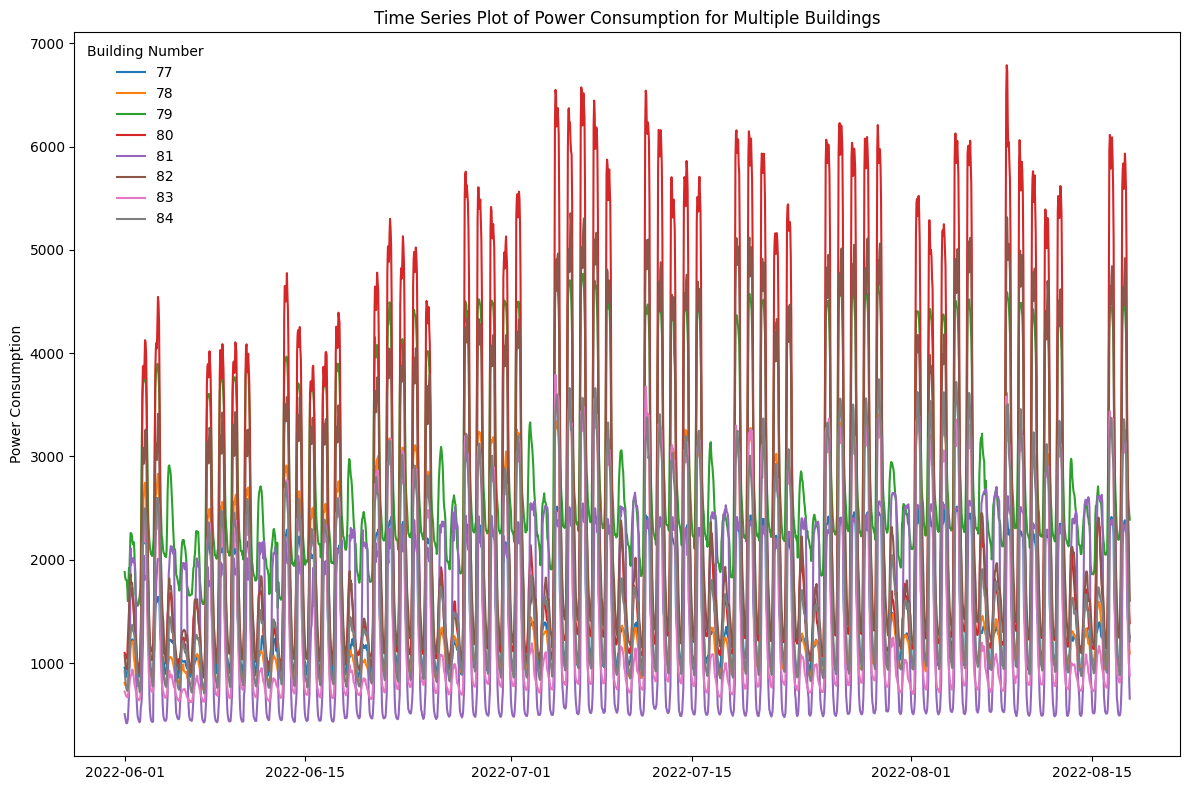

In [ ]:
building_numbers = datak_eda['building_number'].unique()

plt.figure(figsize=(12, 8))

for building in building_numbers:
    building_data = datak_eda[datak_eda['building_number'] == building]
    plt.plot(building_data['date_time'], building_data['power_consumption'], label=building)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time Series Plot of Power Consumption for Multiple Buildings')
plt.ylabel('Power Consumption')
plt.legend(title='Building Number', frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
datak_eda['date_time'] = pd.to_datetime(datak_eda['date_time'])

datak_eda['hour'] = datak_eda['date_time'].dt.hour
datak_eda['day'] = datak_eda['date_time'].dt.day
datak_eda['month'] = datak_eda['date_time'].dt.month
datak_eda['year'] = datak_eda['date_time'].dt.year

In [ ]:
datak_eda['day_of_year'] = datak_eda['date_time'].dt.dayofyear
datak_eda['hour_of_year'] = datak_eda['date_time'].dt.hour + (datak_eda['date_time'].dt.dayofyear - 1) * 24
datak_eda['day_of_week'] = datak_eda['date_time'].dt.dayofweek

In [ ]:
# 년기준 일 평균 소비전력
mean_power_by_day_of_year = datak_eda.groupby('day_of_year')['power_consumption'].mean()

# 년기준 시간평균 소비전력
mean_power_by_hour_of_year = datak_eda.groupby('hour_of_year')['power_consumption'].mean()

# 년기준 월평균 소비전력
mean_power_by_month = datak_eda.groupby('month')['power_consumption'].mean()

# 일기준 시간 평균 소비전력
mean_power_by_hour = datak_eda.groupby('hour')['power_consumption'].mean()

# 월기준 시간 평균 소비전력
mean_power_by_day = datak_eda.groupby('day')['power_consumption'].mean()

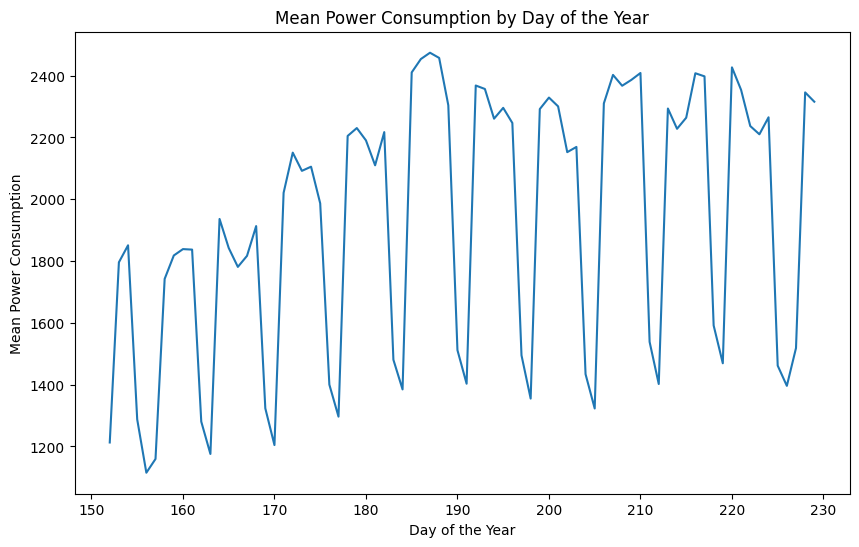

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

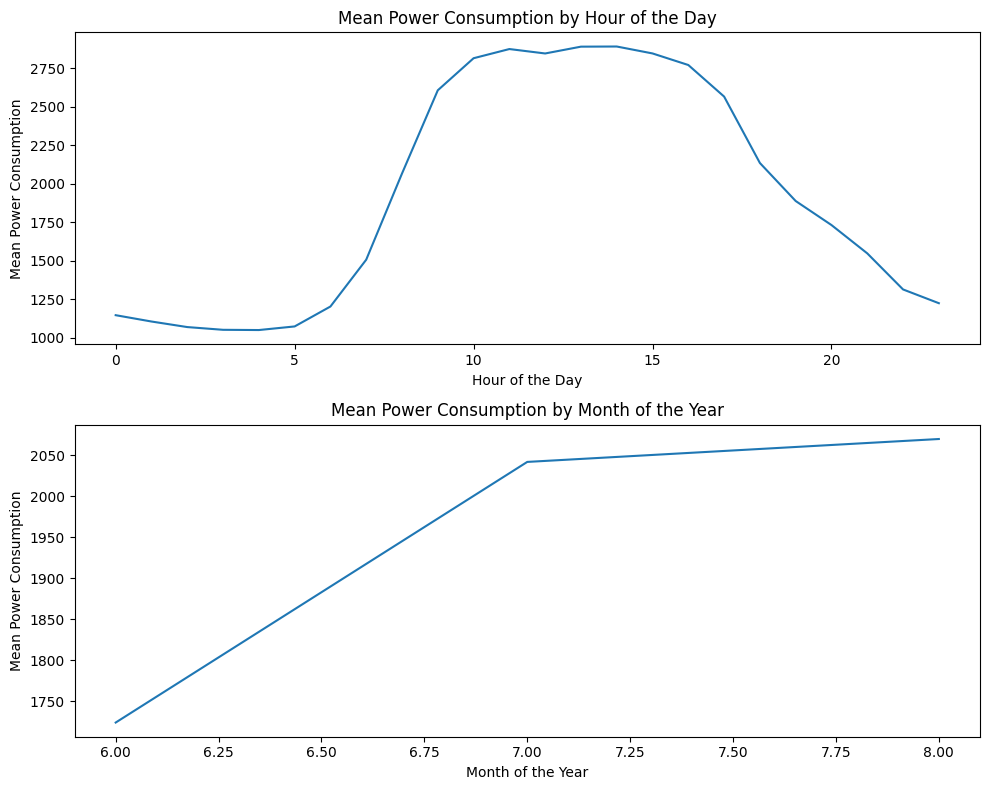

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot mean power consumption by hour of the day
sns.lineplot(x=mean_power_by_hour.index, y=mean_power_by_hour.values, ax=axs[0])
axs[0].set_title('Mean Power Consumption by Hour of the Day')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Mean Power Consumption')

# 년기준 월평균 소비전력
sns.lineplot(x=mean_power_by_month.index, y=mean_power_by_month.values, ax=axs[1])
axs[1].set_title('Mean Power Consumption by Month of the Year')
axs[1].set_xlabel('Month of the Year')
axs[1].set_ylabel('Mean Power Consumption')

plt.tight_layout()
plt.show()

## Rename columns

In [ ]:
datak.shape

(16320, 15)

In [ ]:
df2 = datak.rename(columns={
    'building_number': 'item_id',
    'date_time': 'ds',
    'power_consumption': 'y'
})

# Model 2' - Knowledge data with no covariates

In [ ]:
df_nc = df2[['item_id', 'ds', 'y']]
df_nc.head(2)

,item_id,ds,y
0,77,2022-06-01 00:00:00,954.00
1,77,2022-06-01 01:00:00,934.56


In [ ]:
nc_train = df_nc[df_nc['ds'] <= '2022-08-17 23:00:00']
nc_test = df_nc[df_nc['ds'] >= '2022-08-18 00:00:00']

In [ ]:
results = {}
mspe_results = {}

for item_id in df_nc['item_id'].unique():
    item_data = nc_train[nc_train['item_id'] == item_id]
    item_data2 = nc_test[nc_test['item_id'] == item_id]

    modelk = Prophet()
    modelk.fit(item_data)

    future = modelk.make_future_dataframe(periods=168, freq="h")
    forecast = modelk.predict(future)

    results[item_id] = (item_data, forecast)

    plt.figure(figsize=(10, 6))
    plt.plot(item_data['ds'], item_data['y'], 'k.', label='Observed')
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.6, label='Uncertainty interval')
    plt.title(f"Forecast for item_id {item_id}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    y_true = item_data2['y'].values
    y_pred = forecast['yhat'].values[len(item_data):]
    mspe = np.mean((y_true - y_pred) ** 2)
    mspe_results[item_id] = mspe

for item_id, mspe in mspe_results.items():
    print(f"MSPE for item_id {item_id}: {mspe}")

mspe_df = pd.DataFrame(list(mspe_results.items()), columns=['item_id', 'MSPE'])

mspe_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_prophet_know.csv', index=False)

Output hidden; open in https://colab.research.google.com to view.

prophet MSPE: 196992.3015

AG-TS MSPE: 123324.3660 (nc)

# Model 3' - Knowledge data with covariates

covariates modeling

static: ['total_area', 'cooling_area']

time-varying: ['date of week', 'temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation']

In [ ]:
kr_holidays = holidays.KR(years=2022)

start_date = date(2022, 6, 1)
end_date = date(2022, 8, 24)

for holiday_date, name in sorted(kr_holidays.items()):
    if start_date <= holiday_date <= end_date:
        print(holiday_date, name)

2022-06-01 Local Election Day
2022-06-06 Memorial Day
2022-08-15 Liberation Day


- 6/1 수 지방선거
- 6/6 월 현충일
- 7/17 일 제헌절
- 8/15 월 광복절
- 8/22 에너지의 날

In [ ]:
holidays = pd.DataFrame(kr_holidays.items(), columns=['ds', 'holiday'])
holidays['ds'] = pd.to_datetime(holidays['ds'])
holidays.head()

,ds,holiday
0,2022-01-01,New Year's Day
1,2022-02-01,Korean New Year
2,2022-01-31,The day preceding Korean New Year
3,2022-02-02,The second day of Korean New Year
4,2022-03-01,Independence Movement Day


In [ ]:
df3 = datak.rename(columns={
    'building_number': 'item_id',
    'date_time': 'ds',
    'power_consumption': 'y'
})

In [ ]:
df3['is_weekend'] = df3['ds'].dt.weekday >= 5

In [ ]:
df3['rainfall'] = df3['rainfall'].fillna(0)
df3['sunshine'] = df3['sunshine'].fillna(0)
df3['solar_radiation'] = df3['solar_radiation'].fillna(0)

In [ ]:
wc_train = df3[df3['ds'] <= '2022-08-17 23:00:00']
wc_test = df3[df3['ds'] >= '2022-08-18 00:00:00']

wc_train.tail(2)

,item_id,ds,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,y,building_type,total_area,cooling_area,is_weekend
16150,84,2022-08-17 22:00:00,23.3,0.0,1.5,86.0,0.0,0.0,1317.6,Knowledge Industry Center,174408.2,109973.1,False
16151,84,2022-08-17 23:00:00,23.3,0.0,0.8,86.0,0.0,0.0,1209.6,Knowledge Industry Center,174408.2,109973.1,False


In [ ]:
results = {}
mspe_results = {}

# 각 item_id별로 모델 적합 및 예측 수행
for item_id in df3['item_id'].unique():
    item_data = wc_train[wc_train['item_id'] == item_id]
    item_data2 = wc_test[wc_test['item_id'] == item_id]

    # Prophet 모델 생성 및 추가 회귀 변수 추가
    m = Prophet(holidays=holidays)
    m.add_regressor('temperature')
    m.add_regressor('rainfall')
    m.add_regressor('windspeed')
    m.add_regressor('humidity')
    m.add_regressor('sunshine')
    m.add_regressor('solar_radiation')
    m.add_regressor('total_area')
    m.add_regressor('cooling_area')
    m.add_regressor('is_weekend')
    m.fit(item_data)

    future = m.make_future_dataframe(periods=168, freq="H")
    future_past = future[future['ds'] <= item_data['ds'].max()]
    future_future = future[future['ds'] > item_data['ds'].max()]

    future_past = future_past.merge(item_data[['ds', 'temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation', 'total_area', 'cooling_area', 'is_weekend']],
                                    on='ds', how='left')

    future_future = future_future.merge(item_data2[['ds', 'temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation', 'total_area', 'cooling_area', 'is_weekend']],
                                        on='ds', how='left')

    future = pd.concat([future_past, future_future])

    forecast = m.predict(future)

    results[item_id] = (item_data, forecast)

    plt.figure(figsize=(10, 6))
    plt.plot(item_data['ds'], item_data['y'], 'k.', label='Observed')
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.6, label='Uncertainty interval')
    plt.title(f"Forecast for item_id {item_id}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    y_true = item_data2['y'].values
    y_pred = forecast.loc[forecast['ds'].isin(item_data2['ds']), 'yhat'].values

    print(f"Length of y_pred for item_id {item_id}: {len(y_pred)}")

    mspe = np.mean((y_true - y_pred) ** 2)
    mspe_results[item_id] = mspe

for item_id, mspe in mspe_results.items():
    print(f"MSPE for item_id {item_id}: {mspe}")

mspe_df = pd.DataFrame(list(mspe_results.items()), columns=['item_id', 'MSPE'])
mspe_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_prophet_know_wc.csv', index=False)


Output hidden; open in https://colab.research.google.com to view.

MSPE: 1379347.038 w/ covariates

# Appendix

## Data Integration

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TS/train.csv")
train.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [ ]:
train.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [ ]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

In [ ]:
train.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption
0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [ ]:
building_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TS/building_info.csv', encoding='utf-8')
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [ ]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [ ]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other Buildings,110634.00,39570.00,-,-,-
1,2,Other Buildings,122233.47,99000.00,-,-,-
2,3,Other Buildings,171243.00,113950.00,40,-,-
3,4,Other Buildings,74312.98,34419.62,60,-,-
4,5,Other Buildings,205884.00,150000.00,-,2557,1000


In [ ]:
building_info.to_csv('/content/drive/MyDrive/Colab Notebooks/TS/building_info2.csv')

In [ ]:
data = pd.merge(train, building_info, on='building_number', how='left')

In [ ]:
know = data[data['building_type']=='Knowledge Industry Center']
know.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
155040,77,20220601 00,17.9,NaN,1.0,48.0,NaN,NaN,954.00,Knowledge Industry Center,67377.14,1.0,-,-,-
155041,77,20220601 01,17.7,NaN,1.2,50.0,NaN,NaN,934.56,Knowledge Industry Center,67377.14,1.0,-,-,-
155042,77,20220601 02,17.5,NaN,1.7,49.0,NaN,NaN,873.72,Knowledge Industry Center,67377.14,1.0,-,-,-
155043,77,20220601 03,15.9,NaN,0.4,54.0,NaN,NaN,865.80,Knowledge Industry Center,67377.14,1.0,-,-,-
155044,77,20220601 04,16.6,NaN,2.6,53.0,NaN,NaN,887.40,Knowledge Industry Center,67377.14,1.0,-,-,-


In [ ]:
know.to_csv('/content/drive/MyDrive/TimeSeries/knowledge.csv')

## Model test at bldg no.10

In [ ]:
df4 = df_rdm[df_rdm['item_id'].isin([10])]

In [ ]:
df4.head(2)

,item_id,ds,y
0,10,2022-06-01 00:00:00,3785.76
1,10,2022-06-01 01:00:00,3867.84


In [ ]:
ap_train = df_ap[df_ap['ds'] <= '2022-08-17 23:00:00']
ap_test = df_ap[df_ap['ds'] >= '2022-08-18 0:00:00']

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a3a82qz/w4pvpbrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a3a82qz/r6m4kxg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16631', 'data', 'file=/tmp/tmp_a3a82qz/w4pvpbrv.json', 'init=/tmp/tmp_a3a82qz/r6m4kxg3.json', 'output', 'file=/tmp/tmp_a3a82qz/prophet_modelvcn23v9q/prophet_model-20240625085245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:52:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


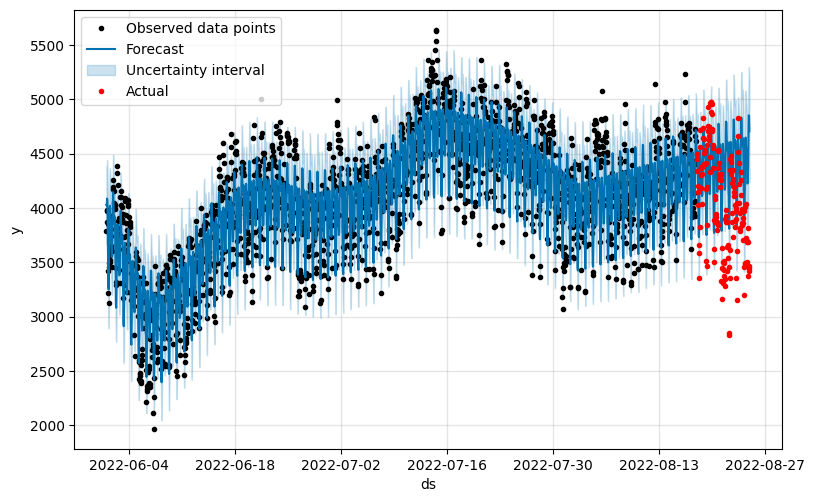

In [ ]:
prophet = Prophet(
    daily_seasonality = True,
    weekly_seasonality = False,
    yearly_seasonality = False
)
m = prophet.fit(ap_train)

future = m.make_future_dataframe(periods=168, freq="H")
fcst = m.predict(future)
fig = m.plot(fcst)

fig.set_size_inches(8, 5)

ax = fig.gca()
ax.plot(ap_test['ds'], ap_test['y'], 'r.', label='Actual')

ax.legend(loc = 'upper left')
plt.show()

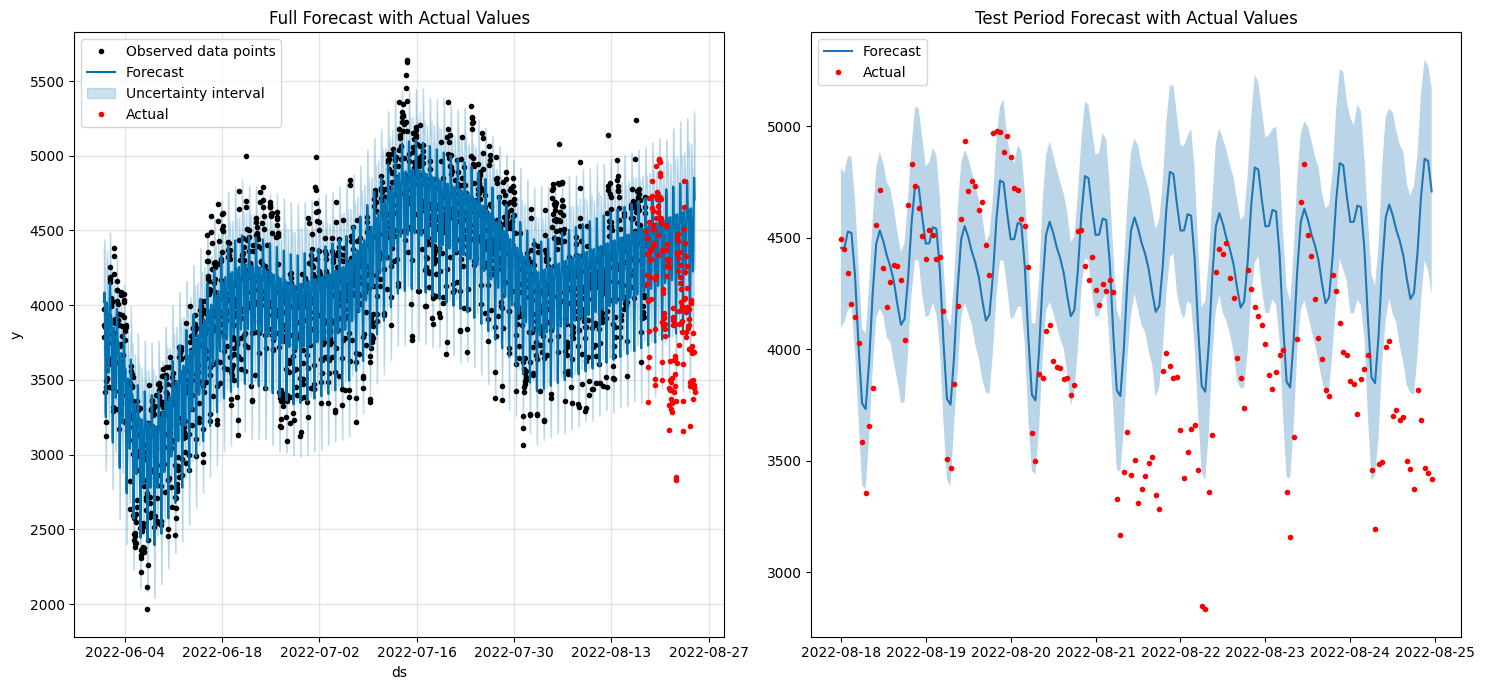

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
# First plot: full forecast with actual test values
m.plot(fcst, ax=ax1)
ax1.plot(ap_test['ds'], ap_test['y'], 'r.', label='Actual')
ax1.legend(loc='upper left')
ax1.set_title('Full Forecast with Actual Values')

# Second plot: forecast for the test period only
fcst_test = fcst[fcst['ds'] >= '2022-08-18 00:00:00']
ax2.plot(fcst_test['ds'], fcst_test['yhat'], label='Forecast')
ax2.fill_between(fcst_test['ds'], fcst_test['yhat_lower'], fcst_test['yhat_upper'], alpha=0.3)
ax2.plot(ap_test['ds'], ap_test['y'], 'r.', label='Actual')
ax2.legend(loc='upper left')
ax2.set_title('Test Period Forecast with Actual Values')

plt.tight_layout()
plt.show()

In [ ]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-06-01 00:00:00,3896.005288,3688.525249,4380.034228,3896.005288,3896.005288,131.991590,131.991590,131.991590,131.991590,131.991590,131.991590,0.0,0.0,0.0,4027.996878
1,2022-06-01 01:00:00,3888.929971,3658.748161,4360.329989,3888.929971,3888.929971,132.193796,132.193796,132.193796,132.193796,132.193796,132.193796,0.0,0.0,0.0,4021.123766
2,2022-06-01 02:00:00,3881.854653,3718.335912,4442.307208,3881.854653,3881.854653,203.925896,203.925896,203.925896,203.925896,203.925896,203.925896,0.0,0.0,0.0,4085.780549
3,2022-06-01 03:00:00,3874.779336,3723.063276,4403.823570,3874.779336,3874.779336,196.407841,196.407841,196.407841,196.407841,196.407841,196.407841,0.0,0.0,0.0,4071.187176
4,2022-06-01 04:00:00,3867.704018,3503.935705,4191.044169,3867.704018,3867.704018,4.852416,4.852416,4.852416,4.852416,4.852416,4.852416,0.0,0.0,0.0,3872.556435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,2022-08-24 19:00:00,4453.716208,3971.473934,4875.605069,4171.639919,4718.332851,-20.354656,-20.354656,-20.354656,-20.354656,-20.354656,-20.354656,0.0,0.0,0.0,4433.361552
2036,2022-08-24 20:00:00,4454.524466,4214.477116,5149.389916,4168.253257,4721.345006,230.784065,230.784065,230.784065,230.784065,230.784065,230.784065,0.0,0.0,0.0,4685.308532
2037,2022-08-24 21:00:00,4455.332725,4397.453789,5297.701173,4165.455813,4725.504124,398.229360,398.229360,398.229360,398.229360,398.229360,398.229360,0.0,0.0,0.0,4853.562085
2038,2022-08-24 22:00:00,4456.140984,4352.193454,5271.929369,4164.137790,4730.303987,387.854754,387.854754,387.854754,387.854754,387.854754,387.854754,0.0,0.0,0.0,4843.995738
